In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 1600
x = np.arange(0, 160000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.00015625 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
# Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    # ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        # ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma)) #- ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) # removed ql

In [6]:
#now write a test
num_steps = 10000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) = model(*test_run) #removed ql

500000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

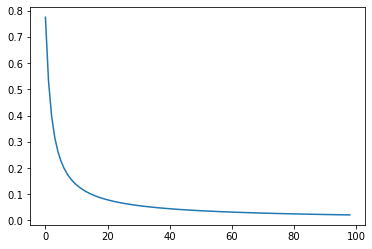

In [8]:
plt.plot(S)

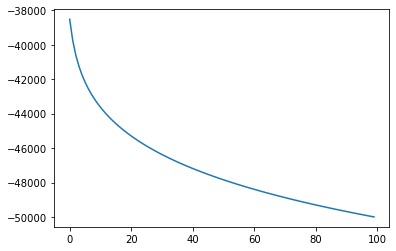

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.021114777419616076

In [11]:
eta

array([-38513.50712994, -39752.68800741, -40602.10862331, -41237.13840602,
       -41743.78987219, -42165.87612974, -42528.33181319, -42846.58175241,
       -43130.78314953, -43387.95607098, -43623.14358758, -43840.08511506,
       -44041.62781061, -44229.98877456, -44406.92819041, -44573.86716124,
       -44731.97003031, -44882.20322116, -45025.37815463, -45162.18312289,
       -45293.20734984, -45418.95942284, -45539.88160282, -45656.36107123,
       -45768.73886945, -45877.31707767, -45982.36463528, -46084.12210132,
       -46182.80558004, -46278.6099824 , -46371.71175491, -46462.27117778,
       -46550.43431206, -46636.33465892, -46720.09458087, -46801.82652538,
       -46881.63408314, -46959.61290724, -47035.85151503, -47110.43199016,
       -47183.43059952, -47254.91833732, -47324.96140637, -47393.62164525,
       -47460.95690847, -47527.0214058 , -47591.86600584, -47655.53850851,
       -47718.08388998, -47779.54452352, -47839.96037896, -47899.36920326,
       -47957.80668437, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([11485.89286321, 10246.71198575,  9397.29136984,  8762.26158714,
        8255.61012096,  7833.52386341,  7471.06817997,  7152.81824075,
        6868.61684362,  6611.44392217,  6376.25640557,  6159.3148781 ,
        5957.77218255,  5769.4112186 ,  5592.47180275,  5425.53283192,
        5267.42996285,  5117.196772  ,  4974.02183852,  4837.21687027,
        4706.19264332,  4580.44057031,  4459.51839034,  4343.03892192,
        4230.66112371,  4122.08291548,  4017.03535788,  3915.27789184,
        3816.59441312,  3720.79001075,  3627.68823824,  3537.12881538,
        3448.96568109,  3363.06533424,  3279.30541229,  3197.57346777,
        3117.76591002,  3039.78708592,  2963.54847812,  2888.96800299,
        2815.96939363,  2744.48165584,  2674.43858679,  2605.77834791,
        2538.44308468,  2472.37858736,  2407.53398732,  2343.86148465,
        2281.31610317,  2219.85546963,  2159.4396142 ,  2100.03078989,
        2041.59330879,  1984.0933931 ,  1927.49903965,  1871.77989623,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_3p_1D.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_3p_1D.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_3p_1D.csv', S, delimiter = ',')

In [15]:
# calc width

b = (kb * Q[1:] * S**(7/6)) / (D**(3/2))

np.savetxt('width csv files/b_exp_3p_1D.csv', b, delimiter = ',')
np.savetxt('Qs csv files/Qs_exp_3p_1D.csv', Qs, delimiter = ',')